*  Q(s,a) değerlerinin ödüllere ve değişen indirim faktörüne bağlı olarak nasıl değişeceğini görmek için mars rover örneğidir.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Do not modify
num_states = 6
num_actions = 2

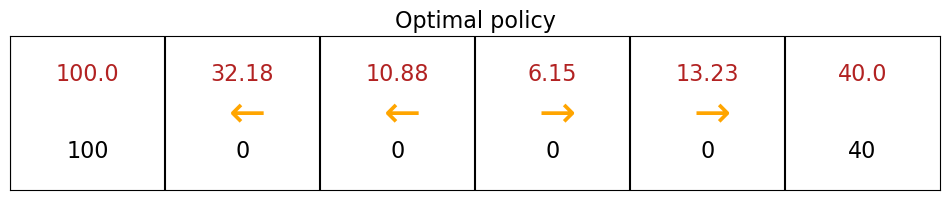

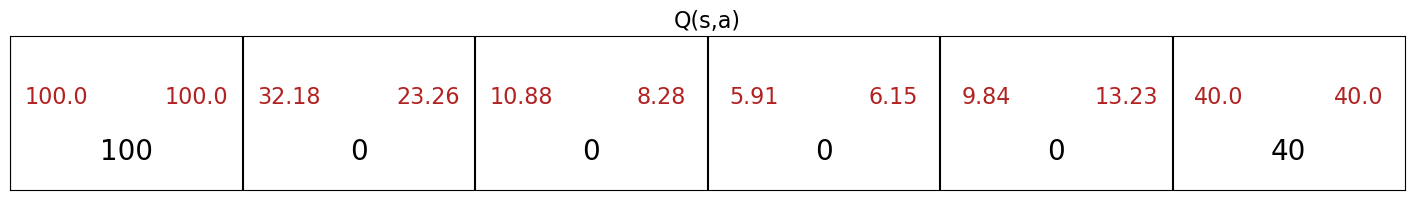

In [6]:
terminal_left_reward = 100
terminal_right_reward = 40
each_step_reward = 0

# Discount factor
gamma = 0.5

# Probability of going in the wrong direction
misstep_prob = 0.4

generate_visualization(terminal_left_reward, terminal_right_reward, 
                       each_step_reward, gamma, misstep_prob)

In [2]:
def generate_rewards(num_states, each_step_reward, terminal_left_reward, terminal_right_reward):

    rewards = [each_step_reward] * num_states
    rewards[0] = terminal_left_reward
    rewards[-1] = terminal_right_reward
    
    return rewards 

def generate_transition_prob(num_states, num_actions, misstep_prob = 0):
    # 0 is left, 1 is right 
    
    p = np.zeros((num_states, num_actions, num_states))
    
    for i in range(num_states):        
        if i != 0:
            p[i, 0, i-1] = 1 - misstep_prob
            p[i, 1, i-1] = misstep_prob
            
        if i != num_states - 1:
            p[i, 1, i+1] = 1  - misstep_prob
            p[i, 0, i+1] = misstep_prob
        
    # Terminal States    
    p[0] = np.zeros((num_actions, num_states))
    p[-1] = np.zeros((num_actions, num_states))
    
    return p

def calculate_Q_value(num_states, rewards, transition_prob, gamma, V_states, state, action):
    q_sa = rewards[state] + gamma * sum([transition_prob[state, action, sp] * V_states[sp] for sp in range(num_states)])
    return q_sa

def evaluate_policy(num_states, rewards, transition_prob, gamma, policy):
    max_policy_eval = 10000 
    threshold = 1e-10
    
    V = np.zeros(num_states)
    
    for i in range(max_policy_eval):
        delta = 0
        for s in range(num_states):
            v = V[s]
            V[s] = calculate_Q_value(num_states, rewards, transition_prob, gamma, V, s, policy[s])
            delta = max(delta, abs(v - V[s]))
                       
        if delta < threshold:
            break
            
    return V

def improve_policy(num_states, num_actions, rewards, transition_prob, gamma, V, policy):
    policy_stable = True
    
    for s in range(num_states):
        q_best = V[s]
        for a in range(num_actions):
            q_sa = calculate_Q_value(num_states, rewards, transition_prob, gamma, V, s, a)
            if q_sa > q_best and policy[s] != a:
                policy[s] = a
                q_best = q_sa
                policy_stable = False
    
    return policy, policy_stable


def get_optimal_policy(num_states, num_actions, rewards, transition_prob, gamma):
    optimal_policy = np.zeros(num_states, dtype=int)
    max_policy_iter = 10000 

    for i in range(max_policy_iter):
        policy_stable = True

        V = evaluate_policy(num_states, rewards, transition_prob, gamma, optimal_policy)
        optimal_policy, policy_stable = improve_policy(num_states, num_actions, rewards, transition_prob, gamma, V, optimal_policy)

        if policy_stable:
            break
            
    return optimal_policy, V

def calculate_Q_values(num_states, rewards, transition_prob, gamma, optimal_policy):
    # Left and then optimal policy
    q_left_star = np.zeros(num_states)

    # Right and optimal policy
    q_right_star = np.zeros(num_states)
    
    V_star =  evaluate_policy(num_states, rewards, transition_prob, gamma, optimal_policy)

    for s in range(num_states):
        q_left_star[s] = calculate_Q_value(num_states, rewards, transition_prob, gamma, V_star, s, 0)
        q_right_star[s] = calculate_Q_value(num_states, rewards, transition_prob, gamma, V_star, s, 1)
        
    return q_left_star, q_right_star


def plot_optimal_policy_return(num_states, optimal_policy, rewards, V):
    actions = [r"$\leftarrow$" if a == 0 else r"$\rightarrow$" for a in optimal_policy]
    actions[0] = ""
    actions[-1] = ""
    
    fig, ax = plt.subplots(figsize=(2*num_states,2))

    for i in range(num_states):
        ax.text(i+0.5, 0.5, actions[i], fontsize=32, ha="center", va="center", color="orange")
        ax.text(i+0.5, 0.25, rewards[i], fontsize=16, ha="center", va="center", color="black")
        ax.text(i+0.5, 0.75, round(V[i],2), fontsize=16, ha="center", va="center", color="firebrick")
        ax.axvline(i, color="black")
    ax.set_xlim([0, num_states])
    ax.set_ylim([0, 1])

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title("Optimal policy",fontsize = 16)

def plot_q_values(num_states, q_left_star, q_right_star, rewards):
    fig, ax = plt.subplots(figsize=(3*num_states,2))

    for i in range(num_states):
        ax.text(i+0.2, 0.6, round(q_left_star[i],2), fontsize=16, ha="center", va="center", color="firebrick")
        ax.text(i+0.8, 0.6, round(q_right_star[i],2), fontsize=16, ha="center", va="center", color="firebrick")

        ax.text(i+0.5, 0.25, rewards[i], fontsize=20, ha="center", va="center", color="black")
        ax.axvline(i, color="black")
    ax.set_xlim([0, num_states])
    ax.set_ylim([0, 1])

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title("Q(s,a)",fontsize = 16)

def generate_visualization(terminal_left_reward, terminal_right_reward, each_step_reward, gamma, misstep_prob):
    num_states = 6
    num_actions = 2
    
    rewards = generate_rewards(num_states, each_step_reward, terminal_left_reward, terminal_right_reward)
    transition_prob = generate_transition_prob(num_states, num_actions, misstep_prob)
    
    optimal_policy, V = get_optimal_policy(num_states, num_actions, rewards, transition_prob, gamma)
    q_left_star, q_right_star = calculate_Q_values(num_states, rewards, transition_prob, gamma, optimal_policy)
    
    plot_optimal_policy_return(num_states, optimal_policy, rewards, V)
    plot_q_values(num_states, q_left_star, q_right_star, rewards)
    